# Semantic search in business news

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

## Boilerplate

### Installation

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.16.0-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'

### Imports and constants

In [2]:
from datetime import datetime, timedelta, timezone

import altair as alt
import pandas as pd

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor, InMemoryApp
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [3]:
MODEL = "sentence-transformers/all-mpnet-base-v2"
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-news-dataset/business_news.json"

## Prepare & explore dataset

In [4]:
business_news = pd.read_json(DATASET_URL, convert_dates=True)

In [5]:
# we are going to need an id column
business_news = business_news.reset_index().rename(columns={"index": "id"})
# we need to handle the timestamp being set in milliseconds
business_news["date"] = [date.replace(tzinfo=timezone.utc).timestamp() for date in business_news.date]

In [6]:
# a sneak peak into the data
business_news.head()

,id,link,headline,category,short_description,authors,date
0,162,https://www.huffpost.com/entry/rei-workers-ber...,REI Workers At Berkeley Store Vote To Unionize...,BUSINESS,They follow in the footsteps of REI workers in...,Dave Jamieson,1.661386e+09
1,353,https://www.huffpost.com/entry/twitter-elon-mu...,Twitter Lawyer Calls Elon Musk 'Committed Enem...,BUSINESS,Delaware Chancery Judge Kathaleen McCormick de...,Marita Vlachou,1.658275e+09
2,632,https://www.huffpost.com/entry/starbucks-leave...,"Starbucks Leaving Russian Market, Shutting 130...",BUSINESS,Starbucks' move follows McDonald's exit from t...,"DEE-ANN DURBIN, AP",1.653264e+09
3,690,https://www.huffpost.com/entry/coinbase-crypto...,Crypto Crash Leaves Trading Platform Coinbase ...,BUSINESS,Cryptocurrency trading platform Coinbase has l...,"Matt Ott, AP",1.652314e+09
4,727,https://www.huffpost.com/entry/us-april-jobs-r...,"US Added 428,000 Jobs In April Despite Surging...",BUSINESS,"At 3.6%, unemployment nearly reached the lowes...","Paul Wiseman, AP",1.651795e+09


### Understand release date distribution

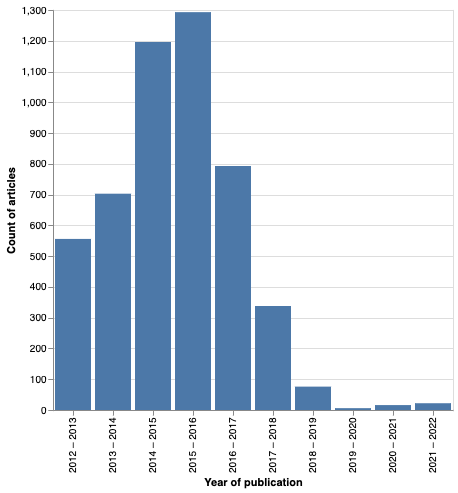

In [7]:
# some quick transformations and an altair histogram
# note that we take a sample to fit into altair's 5000 record limit
years_to_plot: pd.DataFrame = pd.DataFrame(
    {"year_of_publication": [int(datetime.fromtimestamp(ts).year) for ts in business_news["date"]]}).sample(4999)
alt.Chart(years_to_plot).mark_bar().encode(
    alt.X("year_of_publication:N", bin=True, title="Year of publication"),
    y=alt.Y('count()', title="Count of articles"),
).properties(width=400, height=400)

The largest period time should be around 12 years as the oldest article is from 2012.

As most articles are between 2012-2017 therefore 7 years can also make sense to differentiate the relatively scarce recent period.

It can also make sense to give additional weight to more populous time periods - small differences there can be amplified by adding extra weight compared to regions where the data is scarce and differences are larger on average.

## Set up Superlinked

In [8]:
@schema
class NewsSchema:
    description: String
    headline: String
    release_timestamp: Timestamp
    id: IdField

In [9]:
news = NewsSchema()

In [10]:
description_space = TextSimilaritySpace(text=news.description, model=MODEL)
headline_space = TextSimilaritySpace(text=news.headline, model=MODEL)
recency_space = RecencySpace(timestamp=news.release_timestamp, period_time_list=[
    PeriodTime(timedelta(days=7 * YEAR_IN_DAYS), weight=1),
    PeriodTime(timedelta(days=12 * YEAR_IN_DAYS), weight=1)],
    negative_filter=0.0)

In [11]:
news_index = Index(spaces=[description_space, headline_space, recency_space])

In [12]:
query_text_param = Param("query_text")

simple_query = (
    Query(news_index, weights={
        description_space: Param("description_weight"),
        headline_space: Param("headline_weight"),
        recency_space: Param("recency_weight")
    })
    .find(news)
    .similar(description_space.text, query_text_param)
    .similar(headline_space.text, query_text_param)
    .limit(TOP_N)
)

news_query = (
    Query(news_index, weights={
        description_space: Param("description_weight"),
        headline_space: Param("headline_weight"),
        recency_space: Param("recency_weight")
    })
    .find(news)
    .with_vector(news, Param("news_id"))
    .limit(TOP_N)
)

In [13]:
dataframe_parser = DataFrameParser(schema=news, mapping={news.release_timestamp: "date", news.description: "short_description"})

In [14]:
source: InMemorySource = InMemorySource(news, parser=dataframe_parser)
executor: InMemoryExecutor = InMemoryExecutor(sources=[source], indices=[news_index])
app: InMemoryApp = executor.run()

This next one might take a few minutes to run. It is scientifically proven, that watching [this video](https://www.youtube.com/watch?v=1prweT95Mo0&ab_channel=YoYoMaVEVO) will make you feel better and the following cell would also probably run meanwhile. If not, you can still do something quick while smiling.

In [15]:
source.put([business_news])

## Understanding recency

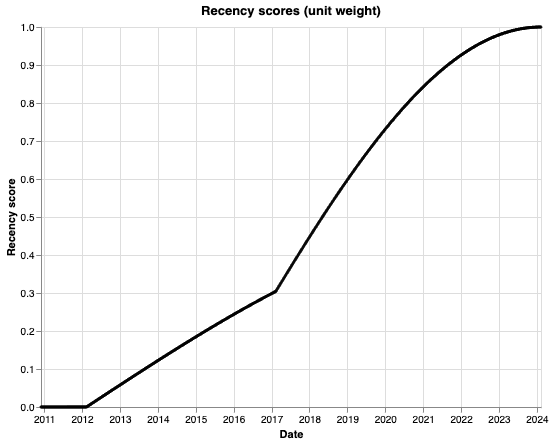

In [16]:
recency_plotter = RecencyPlotter(recency_space)
recency_plotter.plot_recency_curve()

## Queries

In [17]:
# quick helper to present the results in a notebook
def present_result(result: Result, cols_to_keep: list[str] = ["description", "headline", "release_date", "id"]) -> pd.DataFrame:
    # parse result to dataframe
    df: pd.DataFrame = pd.DataFrame([entry.stored_object for entry in result.entries])
    # transform timestamp back to release year. Ts is in milliseconds originally hence the division
    df["release_date"] = [datetime.fromtimestamp(timestamp, tz=timezone.utc).date() for timestamp in df["release_timestamp"]]
    return df[cols_to_keep]

Let's search for one of the biggest acquisitions of the last decade! We are going to set recency's weight to 0 as it does not matter at this point.

In [18]:
result = app.query(
    simple_query,
    query_text = "Microsoft acquires LinkedIn",
    description_weight=1,
    headline_weight=1,
    recency_weight=0
)

present_result(result)

,description,headline,release_date,id
0,(Reuters) - Microsoft Corp agreed to buy Link...,Microsoft Agrees To Acquire LinkedIn For $26.2...,2016-06-13,64890
1,"Without question, LinkedIn has forever altered...",The LinkedIn of Things,2015-01-06,110756
2,LinkedIn works very well for the millions of p...,The 7 LinkedIn Job Search Mistakes That Might ...,2014-06-26,127772
3,Although under-used by average LinkedIn member...,Get LinkedIn to Recruiters for Your Job Search,2014-07-07,126794
4,NEW YORK (AP) — Anthem is buying rival Cigna f...,MEGA-MERGER: Anthem To Buy Cigna For $54 Billion,2015-07-24,93451
5,Facebook and the billionaire Mark Zuckerberg h...,Facebook Is No Longer Cool,2012-02-05,208810
6,The struggling social network is looking for a...,Twitter Is Reportedly In Sales Talks With Goog...,2016-09-23,55880
7,The company's value has soared in the last fiv...,Snapchat Is Reportedly Planning A $25 Billion IPO,2016-10-06,54727
8,If failed corporate mergers teach us anything ...,9 Mergers That Epically Failed,2013-02-23,173078
9,"Another day, another merger. Telephone compani...",The Great Remix: Why Mergers Are Booming,2015-11-01,84610


The first result is about the deal, others are related to some aspect of the query. Let's try upweighting recency to see a recent big acquisition jump to the second place.

In [19]:
result = app.query(
    simple_query,
    query_text = "Microsoft acquires LinkedIn",
    description_weight=1,
    headline_weight=1,
    recency_weight=1,
)

present_result(result)

,description,headline,release_date,id
0,(Reuters) - Microsoft Corp agreed to buy Link...,Microsoft Agrees To Acquire LinkedIn For $26.2...,2016-06-13,64890
1,“My offer is my best and final offer and if it...,Elon Musk Offers To Buy 100% Of Twitter,2022-04-14,849
2,Starbucks' move follows McDonald's exit from t...,"Starbucks Leaving Russian Market, Shutting 130...",2022-05-23,632
3,"Without question, LinkedIn has forever altered...",The LinkedIn of Things,2015-01-06,110756
4,Delaware Chancery Judge Kathaleen McCormick de...,Twitter Lawyer Calls Elon Musk 'Committed Enem...,2022-07-20,353
5,The decision comes as surging oil prices have ...,"Shell Says It Will Stop Buying Russian Oil, Na...",2022-03-08,1054
6,That makes seven Starbucks stores that have vo...,Starbucks Workers In Seattle Vote To Form Union,2022-03-23,967
7,Recent statements by CEO Howard Schultz offer ...,"For The Starbucks Union Campaign, A Bruising C...",2022-04-16,837
8,The store in Arizona joins two in New York as ...,Another Starbucks Store Votes To Unionize,2022-02-25,1117
9,"Android creator Andy Rubin, accused of sexual ...",Google's Alphabet Settles With Shareholders Ov...,2020-09-26,4025


Subsequently we can also search with the news article about Elon Musk offering to buy Twitter. As the dataset is quite biased towards old articles, what we get back is news about either Elon Musk or Twitter.

In [20]:
result = app.query(
    news_query,
    description_weight=1,
    headline_weight=1,
    recency_weight=0,
    news_id="849",
)

present_result(result)

,description,headline,release_date,id
0,“My offer is my best and final offer and if it...,Elon Musk Offers To Buy 100% Of Twitter,2022-04-14,849
1,Don't bet against Musk.,Why Elon Musk’s Plan To Merge Tesla With Solar...,2016-08-16,59220
2,Elon Musk's empire is consolidating.,Tesla Is Buying Sister Company SolarCity For $...,2016-08-01,60483
3,The U.S. Securities and Exchange Commission fi...,SEC Says Elon Musk Violated Fraud Settlement W...,2019-02-26,7191
4,The billionaire wants to marry Tesla and Solar...,The One Company Elon Musk Wants To Keep Indepe...,2016-08-04,60237
5,"The interim CEO purchased 31,000 shares Monday.","Jack Dorsey Bought A Bunch Of Twitter Shares, ...",2015-08-10,91958
6,Tesla's CEO says hiring self-driving engineers...,Elon Musk Just Dropped Another Hint That Tesla...,2015-11-20,82841
7,Time Warner rejected an $80 billion offer from...,"AT&T Agrees To Buy Time Warner, In Principle",2016-10-21,53309
8,"It's an Elon Musk world, and we're just living...",Elon Musk Is Even Smarter Than We Thought,2014-06-14,128870
9,This could all be part of the secret sauce kno...,Wall Street Doesn’t Believe Elon Musk Can Prod...,2016-05-09,67933


That we can start biasing towards recency, navigating the tradeoff of letting less connected but recent news into the mix. 

In [21]:
result = app.query(
    news_query,
    description_weight=1,
    headline_weight=1,
    recency_weight=1,
    news_id="849",
)

present_result(result)

,description,headline,release_date,id
0,“My offer is my best and final offer and if it...,Elon Musk Offers To Buy 100% Of Twitter,2022-04-14,849
1,The U.S. Securities and Exchange Commission fi...,SEC Says Elon Musk Violated Fraud Settlement W...,2019-02-26,7191
2,Delaware Chancery Judge Kathaleen McCormick de...,Twitter Lawyer Calls Elon Musk 'Committed Enem...,2022-07-20,353
3,Recent statements by CEO Howard Schultz offer ...,"For The Starbucks Union Campaign, A Bruising C...",2022-04-16,837
4,"Android creator Andy Rubin, accused of sexual ...",Google's Alphabet Settles With Shareholders Ov...,2020-09-26,4025
5,The assets were the subject of recent talks be...,"Verizon, Comcast Approach 21st Century Fox Abo...",2017-11-16,20285
6,The decision comes as surging oil prices have ...,"Shell Says It Will Stop Buying Russian Oil, Na...",2022-03-08,1054
7,Tesla CEO issues a dire warning.,Elon Musk Predicts The Cause Of World War III ...,2017-09-05,25949
8,Don't bet against Musk.,Why Elon Musk’s Plan To Merge Tesla With Solar...,2016-08-16,59220
9,Starbucks' move follows McDonald's exit from t...,"Starbucks Leaving Russian Market, Shutting 130...",2022-05-23,632
